This repo is based on DiffScaler, https://github.com/DSIP-FBK/DiffScaler/tree/main/src

You are already acquainted with Pytorch now as a fanstastic library for writing, modifying, testing and scaling up the code. In this notebook, let us learn a cool wrapper library for Pytorch known as Pytorch Lightning

A great resource to learn about the differences between Pytorch and Pytorch Lightning and how Pytorch Lightning makes your life easier : https://www.geeksforgeeks.org/deep-learning/pytorch-vs-pytorch-lightning/

Please note that according to this TA, you can`t really appreciate the resurcefulness of Pytorch lightning without learning the basics of Pytorch. Hence, take this tutorial as a 10,000 ft overview of what Pytorch and Pytorch lightning actually do. 

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import torch.nn.functional as F
from lightning import LightningModule, LightningDataModule, Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
import hydra
import random
import zstandard
import os
import glob
import io
import xarray as xr
import rasterio
import rioxarray
import json
import yaml


The original paper this notebook is based on, can be accessed at https://gmd.copernicus.org/articles/18/2051/2025/ . There are originally 14 input channels to predict 2 chanels ultimately : temperature and wind speed. For the purposes of this notebook (due to storage limits and memory issues), we shall only be using low res 2m temperature to predict the high res 2m temperature target field, using hourly data from a single year (2020). 

 But to supplement our endeavours in the form of giving more data to the model, we will also feed in static inputs (inputs that do not change or evolve over time) which are 1. digital elevation model (DEM), 2. land cover categories and 3. latitudinal bands. The functions to do so can be found in the preprocessing file, and we import them here for ease of analysis. 

In [2]:
from preprocessing import load_and_normalise, decompress_zst_pt, get_file_list, collate_fn

In [3]:
# @title
class DownscalingDataset(Dataset):
    def __init__(self, file_list, static_vars, low_2mt_mean, low_2mt_std):
        self.file_list = file_list  # List of (high_file, low_file, date)
        self.static_vars = static_vars  # for a list of static variables, refer the preprocessing file which loads and normalises these datasets
        self.low_2mt_mean = low_2mt_mean
        self.low_2mt_std = low_2mt_std
        self.samples = []
        # Each file contains 24 hourly samples
        for hf, lf, date in self.file_list:
            for hour in range(24):
                self.samples.append((hf, lf, hour))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        hf, lf, hour = self.samples[idx]
        # Loading here high-res and low-res data for the given hour
        high_data = decompress_zst_pt(hf)
        low_data = decompress_zst_pt(lf)
        # the high res and low res (upsampled) low res files are being loaded here
        high_t2m = high_data[hour]["2mT"].float()  #[672, 576]
        low_t2m = low_data[hour]["2mT"].float()    #[84, 72]. : which gives us a super resolution factor of 8!


        high_t2m = high_t2m.unsqueeze(0)  #[1, 672, 576]
        low_t2m = low_t2m.unsqueeze(0)    #[1, 84, 72]
        # Static vars
        dem = self.static_vars["dem"].unsqueeze(0)  #[1, 672, 576]
        lat = self.static_vars["lat"].unsqueeze(0)  #[1, 672, 576]
        lc = self.static_vars["lc"]                 #[bands, 672, 576] ,,,by bands we mean land cover bands here

        #Finally, this returns a dictionary with the following keys and values (variables)
        return {
            "low_2mT": low_t2m,        #[1, 84, 72]
            "high_2mT": high_t2m,      #[1, 672, 576]
            "dem": dem,                #[1, 672, 576]
            "lat": lat,                #[1, 672, 576]
            "lc": lc                   #[bands, 672, 576]
        }

In [4]:
# @title
class DownscalingDataModule(LightningDataModule):
    def __init__(self, batch_size, val_frac, test_frac, num_workers, static_dir, save_stats_json):
        super().__init__()
        self.batch_size = batch_size
        self.val_frac = val_frac
        self.test_frac = test_frac
        self.num_workers = num_workers
        self.static_dir = static_dir
        self.save_stats_json = save_stats_json

    def setup(self, stage=None):
        static_vars, stats = load_and_normalise(
            self.static_dir,
            val_frac=self.val_frac,
            test_frac=self.test_frac,
            save_stats_json=self.save_stats_json
        )
        file_list = get_file_list()
        dataset = DownscalingDataset(
            file_list, static_vars,
            low_2mt_mean=stats["low_2mt_mean"],
            low_2mt_std=stats["low_2mt_std"]
        )
        N = len(dataset)
        n_val = int(self.val_frac * N)
        n_test = int(self.test_frac * N)
        n_train = N - n_val - n_test
        self.train_set, self.val_set, self.test_set = random_split(
            dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42)
        )

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, collate_fn=collate_fn)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, collate_fn=collate_fn)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, collate_fn=collate_fn)

    @property
    def test_dataset(self):
        return self.test_set.dataset



In [5]:
# @title
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, channels, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, channels[0], kernel_size, padding=1)
        self.conv2 = nn.Conv2d(channels[0], channels[1], kernel_size, padding=1)
        self.final = nn.Conv2d(channels[1], out_channels, 1)
    def forward(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        output = self.final(h)
        return output


class UNetLitModule(LightningModule):
    def __init__(
        self,
        net: torch.nn.Module = None,
        lr: float = 1e-3,
        optimizer: dict = None,
        scheduler: dict = None,
        loss_fn: torch.nn.Module = None,
        in_channels: int = 19,
        out_channels: int = 1,
        channels: list = [32, 16],
        kernel_size: int = 3,
        ckpt_path: str = None,
        ignore_keys: list = []
    ):
        super().__init__()
        self.save_hyperparameters(logger=False, ignore=['net', 'loss_fn'])
        self.net = net if net is not None else UNet(
            in_channels=in_channels,
            out_channels=out_channels,
            channels=channels,
            kernel_size=kernel_size
        )
        self.loss_fn = loss_fn if loss_fn is not None else nn.MSELoss()
        self.lr = lr
        self.hparams.optimizer = optimizer
        self.hparams.scheduler = scheduler

    def forward(self, x):
        return self.net(x)

    def model_step(self, batch):
        fuzzy_input, sharp_target = batch
        pred = self.forward(fuzzy_input)
        loss = self.loss_fn(pred, sharp_target)
        return loss, pred

    def training_step(self, batch, batch_idx):
        loss, pred = self.model_step(batch)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, pred = self.model_step(batch)
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, pred = self.model_step(batch)
        self.log("test/loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        opt_cfg = self.hparams.get("optimizer", None)
        sch_cfg = self.hparams.get("scheduler", None)

        if opt_cfg and opt_cfg["type"] == "AdamW":
            optimizer = torch.optim.AdamW(
                self.parameters(),
                lr=opt_cfg.get("lr", self.lr),
                betas=tuple(opt_cfg.get("betas", (0.5, 0.9))),
                weight_decay=opt_cfg.get("weight_decay", 1e-3)
            )
        else:
            optimizer = torch.optim.Adam(
                self.parameters(),
                lr=opt_cfg.get("lr", self.lr) if opt_cfg else self.lr,
                weight_decay=opt_cfg.get("weight_decay", 1e-4) if opt_cfg else 1e-4
            )

        if sch_cfg and sch_cfg["type"] == "ReduceLROnPlateau":
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                patience=sch_cfg.get("patience", 2),
                factor=sch_cfg.get("factor", 0.25)
            )
            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": sch_cfg.get("monitor", "val/loss"),
                    "frequency": 1,
                },
            }
        else:
            return optimizer

In [6]:
# @title
class ResidualsDataModule(LightningDataModule):
    def __init__(self, residuals, batch_size):
        super().__init__()
        self.residuals = residuals
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.dataset = TensorDataset(self.residuals, self.residuals)

    def train_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False)


In [7]:
def kl_divergence(mean, log_var):
    kl = 0.5 * (log_var.exp() + mean.square() - 1.0 - log_var)
    return kl.mean()

def standard_normal_sampling(mean, log_var, num=None):
    std = log_var.mul(0.5).exp()
    shape = mean.shape
    if num is not None:
        shape = shape[:1] + (num,) + shape[1:]
        mean = mean[:, None, ...]
        std = std[:, None, ...]
    return mean + std * torch.randn(shape, device=mean.device)

In [8]:
# @title
class VAE(nn.Module):
    def __init__(
        self,
        latent_dim=32,
        lr=1e-3,
        kl_weight=0.001,
        input_channels=1,
        input_height=672,
        input_width=576,
        encoder_channels=[8],
        decoder_channels=[8],
        optimizer=None,
        scheduler=None,
        **kwargs
    ):
        super().__init__()
        encoder_channels = list(encoder_channels)
        decoder_channels = list(decoder_channels)
        input_height = int(input_height)
        input_width = int(input_width)
        
        self.lr = lr
        self.kl_weight = kl_weight
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, encoder_channels[0], 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.encoded_size = encoder_channels[0] * (input_height // 2) * (input_width // 2)
        self.fc_mu = nn.Linear(self.encoded_size, latent_dim)
        self.fc_logvar = nn.Linear(self.encoded_size, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.encoded_size)
        # Decoder
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (decoder_channels[0], input_height // 2, input_width // 2)),
            nn.ConvTranspose2d(decoder_channels[0], input_channels, 2, stride=2),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Uses the corrected sample_from_standard_normal
        return standard_normal_sampling(mu, logvar)

    def decode(self, z):
        h = self.fc_decode(z)
        return self.decoder(h)

    def forward(self, x, sample_posterior=True):
        mu, logvar = self.encode(x)
        if sample_posterior:
            z = self.reparameterize(mu, logvar)
        else:
            z = mu
        recon = self.decode(z)
        return recon, mu, logvar





class VAELitModule(LightningModule):
    def __init__(
        self,
        latent_dim=32,
        lr=1e-3,
        kl_weight=0.001,
        input_channels=1,
        input_height=672,
        input_width=576,
        encoder_channels=[8],
        decoder_channels=[8],
        optimizer=None,
        scheduler=None,
        **kwargs,
    ):
        super().__init__()
        self.save_hyperparameters(logger=False)
        self.model = VAE(
            latent_dim=latent_dim,
            lr=lr,
            kl_weight=kl_weight,
            input_channels=input_channels,
            input_height=input_height,
            input_width=input_width,
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
        )
        self.lr = lr
        self.kl_weight = kl_weight
        self.hparams.optimizer = optimizer
        self.hparams.scheduler = scheduler

    def forward(self, x, sample_posterior=True):
        return self.model(x, sample_posterior)

    def _loss(self, batch):
        noisy, clean = batch
        recon, mu, logvar = self.forward(clean)

        # Recon loss
        recon_loss = F.l1_loss(recon, clean)

        # KL divergence loss
        kl_loss = kl_divergence(mu, logvar)

        total_loss = recon_loss + self.kl_weight * kl_loss

        return total_loss, recon_loss, kl_loss

    def training_step(self, batch, batch_idx):
        total_loss, recon_loss, kl_loss = self._loss(batch)

        self.log("train/loss", total_loss, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("train/recon_loss", recon_loss, on_step=True, on_epoch=True, sync_dist=True)
        self.log("train/kl_loss", kl_loss, on_step=True, on_epoch=True, sync_dist=True)

        return total_loss

    def validation_step(self, batch, batch_idx):
        total_loss, recon_loss, kl_loss = self._loss(batch)

        self.log("val/loss", total_loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("val/recon_loss", recon_loss, on_step=False, on_epoch=True, sync_dist=True)
        self.log("val/kl_loss", kl_loss, on_step=False, on_epoch=True, sync_dist=True)

        return total_loss

    def test_step(self, batch, batch_idx):
        total_loss, recon_loss, kl_loss = self._loss(batch)

        self.log("test/loss", total_loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("test/recon_loss", recon_loss, on_step=False, on_epoch=True, sync_dist=True)
        self.log("test/kl_loss", kl_loss, on_step=False, on_epoch=True, sync_dist=True)

        return total_loss

    def configure_optimizers(self):
        # Example: using self.hparams for optimizer/scheduler settings from config
        opt_cfg = self.hparams.get("optimizer", None)
        sch_cfg = self.hparams.get("scheduler", None)

        if opt_cfg and opt_cfg["type"] == "AdamW":
            optimizer = torch.optim.AdamW(
                self.parameters(),
                lr=opt_cfg.get("lr", self.lr),
                betas=tuple(opt_cfg.get("betas", (0.5, 0.9))),
                weight_decay=opt_cfg.get("weight_decay", 1e-3)
            )
        else:
            optimizer = torch.optim.Adam(
                self.parameters(),
                lr=opt_cfg.get("lr", self.lr) if opt_cfg else self.lr,
                weight_decay=opt_cfg.get("weight_decay", 1e-4) if opt_cfg else 1e-4
            )

        if sch_cfg and sch_cfg["type"] == "ReduceLROnPlateau":
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                patience=sch_cfg.get("patience", 3),
                factor=sch_cfg.get("factor", 0.25)
            )
            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": sch_cfg.get("monitor", "val/recon_loss"),
                    "frequency": 1,
                },
            }
        else:
            return optimizer

In [9]:
# @title
class LatentDenoiser(nn.Module):
    def __init__(self, latent_dim=64, hidden_dim=128, num_layers=4):  # always make sure to have a config file ,, these are just default in case no information is provided in config.
    #We will talk about config files later in the exercise at the bottom, wherre everything comes togetehr and makes sense.
        super().__init__()
        self.latent_dim = latent_dim
        self.time_embed = nn.Sequential(
            nn.Linear(1, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim)
        )
        layers = []
        layers.append(nn.Linear(latent_dim * 2, hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.LayerNorm(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))
        layers.append(nn.Linear(hidden_dim, latent_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, z_noisy, timestep=None):
        if timestep is None:
            timestep = torch.zeros(z_noisy.shape[0], 1, device=z_noisy.device)
        if timestep.max() > 1.0:
            timestep = timestep / 1000.0
        t_embed = self.time_embed(timestep.float())
        x = torch.cat([z_noisy, t_embed], dim=-1)
        return self.net(x)




class LDMLitModule(LightningModule):
    def __init__(
        self,
        vae,
        latent_dim=64,
        lr=1e-4,
        num_timesteps=50,
        noise_schedule="linear",
        loss_type="l2",
        hidden_dim=128,
        num_layers=4,
        optimizer=None,
        scheduler=None,
        **kwargs
    ):
        super().__init__()
        # Save all hyperparameters except vae
        self.save_hyperparameters(logger=False, ignore=['vae'])
        self.vae = vae.model.requires_grad_(False)
        self.vae.eval()
        # Pass config values to LatentDenoiser
        self.denoiser = LatentDenoiser(latent_dim, hidden_dim, num_layers)
        self.lr = lr
        self.num_timesteps = num_timesteps
        self.loss_type = loss_type
        self.register_noise_schedule(noise_schedule)
        if loss_type == "l1":
            self.loss_fn = nn.L1Loss()
        elif loss_type == "l2":
            self.loss_fn = nn.MSELoss()
        else:
            raise ValueError(f"Unknown loss type: {loss_type}")

    def register_noise_schedule(self, schedule="linear"):
        if schedule == "linear":
            betas = torch.linspace(1e-4, 2e-2, self.num_timesteps)
        elif schedule == "cosine":
            timesteps = torch.arange(self.num_timesteps + 1) / self.num_timesteps
            alphas = torch.cos(timesteps * torch.pi / 2) ** 2
            alphas = alphas / alphas[0]
            betas = 1 - alphas[1:] / alphas[:-1]
            betas = torch.clamp(betas, 0, 0.999)
        else:
            raise ValueError(f"Unknown schedule: {schedule}")
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        self.register_buffer('betas', betas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1 - alphas_cumprod))

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)
        return (sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise)

    def p_losses(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        x_noisy = self.q_sample(x_start, t, noise)
        predicted_noise = self.denoiser(x_noisy, t.unsqueeze(1))
        loss = self.loss_fn(predicted_noise, noise)
        return loss

    def forward(self, x):
        batch_size = x.shape[0]
        with torch.no_grad():
            mu, logvar = self.vae.encode(x)
            z = self.vae.reparameterize(mu, logvar)
        t = torch.randint(0, self.num_timesteps, (batch_size,), device=self.device)
        loss = self.p_losses(z, t)
        return loss

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        loss = self.forward(clean)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        loss = self.forward(clean)
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def test_step(self, batch, batch_idx):
        noisy, clean = batch
        loss = self.forward(clean)
        self.log("test/loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    @torch.no_grad()
    def sample(self, shape, num_steps=50):
        z = torch.randn(shape, device=self.device)
        timesteps = torch.linspace(self.num_timesteps-1, 0, num_steps, dtype=torch.long, device=self.device)
        for i, t in enumerate(timesteps):
            t_batch = t.repeat(shape[0])
            predicted_noise = self.denoiser(z, t_batch.unsqueeze(1))
            alpha_t = self.alphas_cumprod[t]
            alpha_t_prev = self.alphas_cumprod[t-1] if t > 0 else torch.tensor(1.0)
            pred_x0 = (z - torch.sqrt(1 - alpha_t) * predicted_noise) / torch.sqrt(alpha_t)
            if t > 0:
                noise = torch.randn_like(z) if i < len(timesteps) - 1 else 0
                z = (torch.sqrt(alpha_t_prev) * pred_x0 + torch.sqrt(1 - alpha_t_prev) * noise)
            else:
                z = pred_x0
        return z

    @torch.no_grad()
    def generate_samples(self, num_samples=1):
        latent_shape = (num_samples, self.hparams.latent_dim)
        z_samples = self.sample(latent_shape)
        samples = self.vae.decode(z_samples)
        return samples

    def configure_optimizers(self):
        opt_cfg = self.hparams.get("optimizer", None)
        sch_cfg = self.hparams.get("scheduler", None)

        if opt_cfg and opt_cfg["type"] == "AdamW":
            optimizer = torch.optim.AdamW(
                self.parameters(),
                lr=opt_cfg.get("lr", self.lr),
                betas=tuple(opt_cfg.get("betas", (0.5, 0.9))),
                weight_decay=opt_cfg.get("weight_decay", 1e-3)
            )
        else:
            optimizer = torch.optim.Adam(
                self.parameters(),
                lr=opt_cfg.get("lr", self.lr) if opt_cfg else self.lr,
                weight_decay=opt_cfg.get("weight_decay", 1e-4) if opt_cfg else 1e-4
            )

        if sch_cfg and sch_cfg["type"] == "ReduceLROnPlateau":
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                patience=sch_cfg.get("patience", 5),
                factor=sch_cfg.get("factor", 0.5)
            )
            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": sch_cfg.get("monitor", "val/loss"),
                    "frequency": 1,
                },
            }
        else:
            return optimizer


In [10]:
def train_hierarchy(cfg):
    data_module = DownscalingDataModule(
        batch_size=cfg.data.batch_size,
        val_frac=cfg.data.val_split,
        test_frac=cfg.data.test_split,
        num_workers=cfg.data.num_workers,
        static_dir=cfg.paths.static_dir,
        save_stats_json=os.path.join(cfg.paths.output_dir, "stats.json")
    )
    data_module.setup()

    checkpoint_dir = cfg.paths.checkpoint_dir
    os.makedirs(checkpoint_dir, exist_ok=True)

    # UNet
    unet_module = UNetLitModule(
    net=UNet(
        in_channels=cfg.model.unet.in_channels,
        out_channels=cfg.model.unet.out_channels,
        channels=cfg.model.unet.channels,
        kernel_size=cfg.model.unet.kernel_size,
    ),
    lr=cfg.model.unet.lr,
    optimizer=cfg.optimizer.unet,
    scheduler=cfg.scheduler.unet,
)
    unet_checkpoint = ModelCheckpoint(
        dirpath=checkpoint_dir + "/unet",
        filename="unet-{epoch:02d}",
        save_top_k=1,
        monitor="val/loss",
        mode="min",
    )
    trainer_unet = Trainer(
        max_epochs=cfg.training.unet_epochs,
        accelerator=cfg.trainer.accelerator,
        gradient_clip_val=cfg.trainer.get("gradient_clip_val", 1.0),
        enable_checkpointing=True,
        logger=False,
        callbacks=[unet_checkpoint],
    )
    trainer_unet.fit(unet_module, datamodule=data_module)

    # Residuals
    residuals = []
    for batch in data_module.train_dataloader():
        fuzzy_input, sharp_target = batch
        with torch.no_grad():
            pred = unet_module.net(fuzzy_input)
            residual = sharp_target - pred
            residuals.append(residual)
    residuals = torch.cat(residuals, dim=0)
    print(f"Residuals shape: {residuals.shape}") #This is a debug step, as the VAE training had nans
    print("residual nans:",torch.isnan(residuals).any())

    # VAE
    vae_module = VAELitModule(
        latent_dim=cfg.model.vae.latent_dim,
        lr=cfg.model.vae.lr,
        kl_weight=cfg.model.vae.kl_weight,
        input_channels=cfg.model.vae.input_channels,
        input_height=cfg.model.vae.input_height,
        input_width=cfg.model.vae.input_width,
        encoder_channels=cfg.model.vae.encoder_channels,
        decoder_channels=cfg.model.vae.decoder_channels,
        optimizer=cfg.optimizer.vae,
        scheduler=cfg.scheduler.vae,
    )

    vae_checkpoint = ModelCheckpoint(
        dirpath=checkpoint_dir + "/vae",
        filename="vae-{epoch:02d}",
        save_top_k=1,
        monitor="val/loss",
        mode="min",
    )
    residual_data_module = ResidualsDataModule(residuals, cfg.data.batch_size)
    residual_data_module.setup()


    trainer_vae = Trainer(
        max_epochs=cfg.training.vae_epochs,
        accelerator=cfg.trainer.accelerator,
        enable_checkpointing=True,
        logger=False,
        default_root_dir=checkpoint_dir + "/vae",
        callbacks=[vae_checkpoint],
    )
    trainer_vae.fit(vae_module, datamodule=residual_data_module)

    # LDM
    ldm_module = LDMLitModule(
        vae=vae_module,
        latent_dim=cfg.model.ldm.latent_dim,
        lr=cfg.model.ldm.lr,
        num_timesteps=cfg.model.ldm.num_timesteps,
        noise_schedule=cfg.model.ldm.noise_schedule,
        loss_type=cfg.model.ldm.loss_type,
        hidden_dim=cfg.model.ldm.hidden_dim,
        num_layers=cfg.model.ldm.num_layers,
        optimizer=cfg.optimizer.ldm,
        scheduler=cfg.scheduler.ldm,
    )
    ldm_checkpoint = ModelCheckpoint(
        dirpath=checkpoint_dir + "/ldm",
        filename="ldm-{epoch:02d}",
        save_top_k=1,
        monitor="val/loss",
        mode="min",
    )
    trainer_ldm = Trainer(
        max_epochs=cfg.training.ldm_epochs,
        accelerator=cfg.trainer.accelerator,
        enable_checkpointing=True,
        logger=False,
        default_root_dir=checkpoint_dir + "/ldm",
        callbacks=[ldm_checkpoint],
    )
    trainer_ldm.fit(ldm_module, datamodule=residual_data_module)


In [11]:
# @title

config = {
    "model": {
        "unet": {
            "in_channels": 19,
            "out_channels": 1,
            "lr": 1e-4,
            "channels": [32, 16],
            "kernel_size": 3
        },
        "vae": {
            "latent_dim": 32,
            "input_channels": 1,
            "input_height": 672,
            "input_width": 576, #Dimensions of the input image
            "lr": 1e-4,
            "kl_weight": 0.001,
            "encoder_channels": [8],
            "decoder_channels": [8]
        },
        "ldm": {
            "latent_dim": 32,
            "lr": 1e-4,
            "num_timesteps": 20,
            "noise_schedule": "linear",
            "loss_type": "l2",
            "hidden_dim": 64,
            "num_layers": 2
        }
    },
    "trainer": {
        "max_epochs": 10,
        "min_delta": 1e-4,
        "accelerator": "gpu", # Changed from "auto" to "gpu"....make sure you run on a gpu, else it shall take ages
        "gradient_clip_val": 1.0
    },
    "training": {
        "unet_epochs": 30,
        "vae_epochs": 20,
        "ldm_epochs": 20
    },
    "optimizer": {
        "unet": {
            "type": "Adam",
            "lr": 1e-4,
            "weight_decay": 1e-4
        },
        "vae": {
            "type": "AdamW",
            "lr": 1e-4,
            "betas": [0.5, 0.9],
            "weight_decay": 1e-3
        },
        "ldm": {
            "type": "AdamW",
            "lr": 1e-4,
            "betas": [0.5, 0.9],
            "weight_decay": 1e-3
        }
    },
    "scheduler": {
        "unet": {
            "type": "ReduceLROnPlateau",
            "patience": 2,
            "factor": 0.25,
            "monitor": "val/loss"
        },
        "vae": {
            "type": "ReduceLROnPlateau",
            "patience": 2,
            "factor": 0.25,
            "monitor": "val/recon_loss"
        },
        "ldm": {
            "type": "ReduceLROnPlateau",
            "patience": 2,
            "factor": 0.25,
            "monitor": "val/loss"
        }
    },

    "data": {
        "batch_size": 16,
        "test_split": 0.15,
        "val_split": 0.15,
        "num_workers": 1
    },
    "paths": {
        "checkpoint_dir": "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/TA_work/checkpoints",
        "output_dir": "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/TA_work/outputs_dir",
        "data_dir": "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/TA_work/DiffScaler/data",
        "static_dir": "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/TA_work/DiffScaler/data/static_var"
    },
    "seed": 42
}

In [12]:
with open("conf/config_experiments.yaml", "w") as f:
    yaml.dump(config, f)

In [13]:
if __name__ == "__main__":
    cfg = OmegaConf.load("conf/config_experiments.yaml")
    train_hierarchy(cfg)

Using 48 samples from 2020.


/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/D ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Using 48 samples from 2020.


You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Using 48 samples from 2020.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | net     | UNet    | 10.1 K | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
10.1 K    Trainable params
0         Non-trainable params
10.1 K    Total params
0.041     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Using 48 samples from 2020.
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 29: 100%|██████████| 51/51 [01:03<00:00,  0.80it/s, train/loss_step=0.0445, val/loss=0.0399, train/loss_epoch=0.0407]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 51/51 [01:03<00:00,  0.80it/s, train/loss_step=0.0445, val/loss=0.0399, train/loss_epoch=0.0407]
Residuals shape: torch.Size([808, 1, 672, 576])
residual nans: tensor(False)


/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/D ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | VAE  | 75.1 M | train
---------------------------------------
75.1 M    Trainable params
0         Non-trainable params
75.1 M    Total params
300.369   Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 51/51 [00:37<00:00,  1.36it/s, train/loss_step=0.123, val/loss=0.133, train/loss_epoch=0.135]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 51/51 [00:38<00:00,  1.32it/s, train/loss_step=0.123, val/loss=0.133, train/loss_epoch=0.135]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type           | Params | Mode 
----------------------------------------------------
0 | vae      | VAE            | 75.1 M | eval 
1 | denoiser | LatentDenoiser | 7.4 K  | train
2 | loss_fn  | MSELoss        | 0      | train
----------------------------------------------------
7.4 K     Trainable params
75.1 M    Non-trainable params
75.1 M    Total params
300.398   Total estimated model params size (MB)
10        Modules in train mode
13        Modules in eval mode



Epoch 19: 100%|██████████| 51/51 [00:37<00:00,  1.36it/s, train/loss_step=0.915, val/loss=0.991, train/loss_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 51/51 [00:37<00:00,  1.36it/s, train/loss_step=0.915, val/loss=0.991, train/loss_epoch=1.000]


In [14]:
def inference(cfg):
    # Load stats for denormalisation
    stats_path = os.path.join(cfg.paths.output_dir, "stats.json")
    with open(stats_path, "r") as f:
        stats = json.load(f)
    low_2mt_mean = stats["low_2mt_mean"]
    low_2mt_std = stats["low_2mt_std"]

    def denormalise(arr):
        return arr * low_2mt_std + low_2mt_mean

    # Instantiate and set up the LightningDataModule
    data_module = DownscalingDataModule(
        batch_size=cfg.data.batch_size,
        val_frac=cfg.data.val_split,
        test_frac=cfg.data.test_split,
        num_workers=cfg.data.get("num_workers", 1),
        static_dir=cfg.paths.static_dir,
        save_stats_json=os.path.join(cfg.paths.output_dir, "stats.json")
    )
    data_module.setup()
    checkpoint_dir = cfg.paths.checkpoint_dir

    # Load checkpoints from each step of the hierarchy trained above
    unet_module = UNetLitModule.load_from_checkpoint(
        os.path.join(checkpoint_dir, "unet", sorted(os.listdir(checkpoint_dir + "/unet"))[-1])  #chosing the last ckpt
    )
    vae_module = VAELitModule.load_from_checkpoint(
        os.path.join(checkpoint_dir, "vae", sorted(os.listdir(checkpoint_dir + "/vae"))[-1])
    )
    ldm_module = LDMLitModule.load_from_checkpoint(
        os.path.join(checkpoint_dir, "ldm", sorted(os.listdir(checkpoint_dir + "/ldm"))[-1]),
        vae=vae_module
    )

    test_dataset = data_module.test_dataset

    # Three models in eval() mode
    unet_module.eval()
    vae_module.eval()
    ldm_module.eval()

    # visualising a single random test sample
    idx = random.randint(0, len(test_dataset)-1)
    sample = test_dataset[idx]
    if isinstance(sample, dict):
        fuzzy_input = torch.cat([
            F.interpolate(sample["low_2mT"].unsqueeze(0), size=sample["high_2mT"].shape[-2:], mode='bilinear', align_corners=False),
            sample["dem"].unsqueeze(0),
            sample["lat"].unsqueeze(0),
            sample["lc"].unsqueeze(0)
        ], dim=1).squeeze(0)
        sharp_target = sample["high_2mT"]
    else:
        fuzzy_input, sharp_target = sample

    with torch.no_grad():
        device = next(unet_module.parameters()).device
        fuzzy_input = fuzzy_input.unsqueeze(0).to(device)
        unet_pred = unet_module.net(fuzzy_input)
        residual = sharp_target.to(device) - unet_pred
        mu, logvar = vae_module.model.encode(residual)
        latents = standard_normal_sampling(mu, logvar, num=3)
        generated_residuals = vae_module.model.decode(latents.view(-1, latents.shape[-1]))


        final_reconstructions = unet_pred + generated_residuals

    all_imgs = [
        denormalise(sharp_target[0].cpu().numpy()),
        denormalise(fuzzy_input[0, 0].cpu().numpy()),
        denormalise(unet_pred[0, 0].cpu().numpy()),
    ] + [denormalise(final_reconstructions[i, 0].cpu().numpy()) for i in range(3)]
    vmin = min(img.min() for img in all_imgs)
    vmax = max(img.max() for img in all_imgs)

    fig, axes = plt.subplots(1, 6, figsize=(30, 5))
    titles = [
        "Original High-Res",
        "Low-Res Input (Upsampled)",
        "UNet Prediction",
        "Sample 1",
        "Sample 2",
        "Sample 3"
    ]
    images = []

    images.append(axes[0].imshow(all_imgs[0], cmap='viridis', vmin=vmin, vmax=vmax))
    axes[0].set_title(titles[0])
    axes[0].axis('off')

    images.append(axes[1].imshow(all_imgs[1], cmap='viridis', vmin=vmin, vmax=vmax))
    axes[1].set_title(titles[1])
    axes[1].axis('off')

    images.append(axes[2].imshow(all_imgs[2], cmap='viridis', vmin=vmin, vmax=vmax))
    axes[2].set_title(titles[2])
    axes[2].axis('off')

    for i in range(3):
        images.append(axes[3+i].imshow(all_imgs[3+i], cmap='viridis', vmin=vmin, vmax=vmax))
        axes[3+i].set_title(titles[3+i])
        axes[3+i].axis('off')

    fig.colorbar(images[0], ax=axes, orientation='horizontal', fraction=0.015, pad=0.04)
    plt.suptitle("Ground Truth + UNet Prediction + LDM Samples")
    plt.tight_layout()
    plt.show()

Using 48 samples from 2020.
Using 48 samples from 2020.


/tmp/ipykernel_2157674/3884182184.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


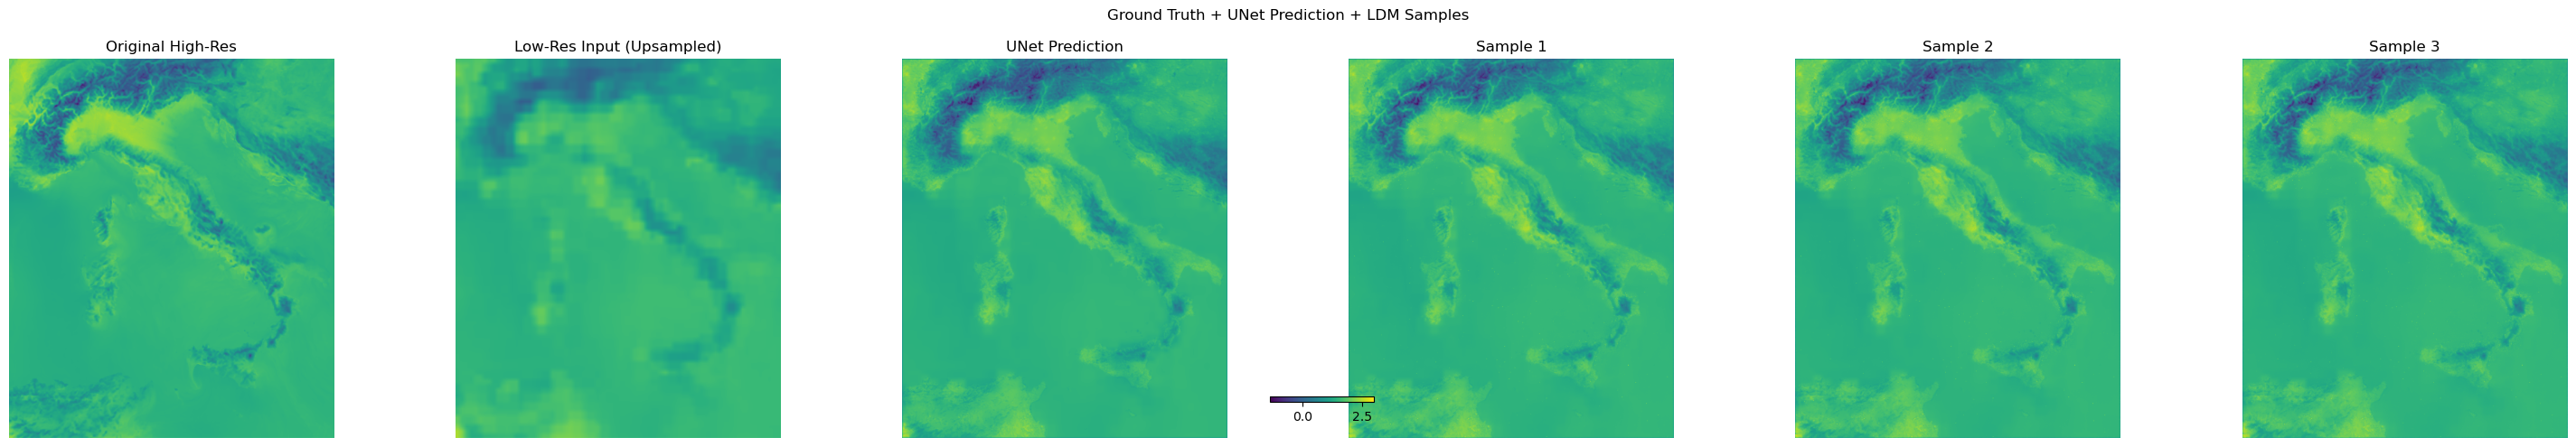

In [15]:
#Now that the models are trained,,, how will you perform inference using the trained hierarchy?
inference(cfg)

Part II : Hydra : the one stop solution to all your experimental needs !!

If you are curious about other configuration managers,,, this TA would highly recommend Hydra, conventionally almost always used with Pytorch lightning for conducting experiments without using the source code,

For piquing your curiosity, here is the adorable Hydra logo. 